# Two-spin transverse-Ising jump operators

In [1]:
include("notebook_preamble.jl");

In [2]:
using Revise
includet("TransverseIsingModels.jl")
using .TransverseIsingModels
TIM = TransverseIsingModels;

In [3]:
using SymPy
⊗ₖ = kron;

In [4]:
σ0 = [1 0; 0 1];  σx = [0 1; 1 0]; σy = [0 -im; im 0];
σz = [1 0; 0 -1]; σp = [0 1; 0 0]; σm = [0 0; 1 0];

In [5]:
function symeigen(H)
    symeig = H.eigenvects()
    vals, vecs = eltype(H)[], []
    for (λ, _, vs) in symeig
        for v in vs
            push!(vals, λ)
            push!(vecs, vec(v))
        end
    end
    vals, vecs
end;

function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

firstvalue(i, (x, y)) = x
lastvalue(i,  (x, y)) = y
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

import QuantumOpticsBase.projector
projector(ψ::Vector{Sym}) = ψ * ψ';

Note that comparison of energy differences is decidable by the Tarski–Seidenberg theorem.

In [6]:
function symbolicjumps(vals, vecs; combine=false)
    eigendict = dictby(zip(vals, vecs))
    ωs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict) for E2 in keys(eigendict)))
    As = [σx ⊗ₖ σ0,  σy ⊗ₖ σ0,  σz ⊗ₖ σ0, σ0 ⊗ₖ σx,  σ0 ⊗ₖ σy,  σ0 ⊗ₖ σz]
    Πs = TIM.projectors(eigendict)
    Jωs = dictmap(ΔEs -> filter(!iszero, [simplify.(sum(Πs[E1]*A*Πs[E2] for (E1, E2) in ΔEs)) for A in As]), ωs)
    combine ? dictmap(combinejumps, Jωs) : Jωs
end;

isnegation(s) = (isreal(s) && s < 0) || (s.func.__name__ == "Mul" && isreal(s.args[1]) && s.args[1] < 0);

function spinop(l, r, i)
    if l == 0 && r == 0
        L"\sigma_%$i^+ \sigma_%$i^-"
    elseif l == 0 && r == 1
        L"\sigma_%$i^+"
    elseif l == 1 && r == 0
        L"\sigma_%$i^-"
    elseif l == 1 && r == 1
        L"\sigma_%$i^- \sigma_%$i^+"
    end
end;

function jumplatex(J)
    _, s = mapreduce(((nx, x), (ny, y)) -> (nx, latexstring(x, ny ? "" : " + ", y)),
        CartesianIndices(J)[J .!= 0]) do I
        x = J[I]
        lx = sympy.latex(x)
        i, j = Tuple(I - CartesianIndex(1, 1))
        c = x.func.__name__ == "Add" ? "\\left(" * lx * "\\right)" : lx
        term = latexstring(L"%$c \; ", spinop(i÷2, j÷2, 1), spinop(i%2, j%2, 2))
        isnegation(x), term
    end
    s
end;

displayjump(J) = (display(J); display(jumplatex(J)));

function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [√(Sym(N))*J for (J, N) in d]
end;

The $\omega = 0$ operators have a duplicate jump operator for the z-spin interactions. Issue: it's projector is not idempotent?

$N$ repeated jump operators are equivalent to one weighted with $\sqrt{N}$?

## Nondegenerate case ($g > 0$)

In [7]:
@vars g real=true
H = -2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)

4×4 Array{Sym,2}:
 -2⋅g   0   0   -2
    0   0  -2    0
    0  -2   0    0
   -2   0   0  2⋅g

In [8]:
vals, vecs = symeigen(H);
vals'

1×4 Adjoint{Sym,Array{Sym,1}}:
 -2  2  -2*sqrt(g^2 + 1)  2*sqrt(g^2 + 1)

In [9]:
Jωs = symbolicjumps(vals, vecs; combine=true)
sum(length(Js) for Js in values(Jωs))

23

Now the full jump operators are:

\tiny

In [10]:
for Js in values(Jωs), J in Js
    displayjump(J)
end

4×4 Array{Sym,2}:
                        2⋅√2  0  0  sqrt(2)*(-2*g + 2*sqrt(g^2 + 1))
                                0  0  0                                 0
                                0  0  0                                 0
 sqrt(2)*(-2*g - 2*sqrt(g^2 + 1))  0  0                        -2⋅√2

L"$2 \sqrt{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\sqrt{2} \left(- 2 g - 2 \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^-$ + $\sqrt{2} \left(- 2 g + 2 \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+$$- 2 \sqrt{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
                                         0  …                      0
 g + (g + sqrt(g^2 + 1))^2 + sqrt(g^2 + 1)     g + sqrt(g^2 + 1) + 1
 g + (g + sqrt(g^2 + 1))^2 + sqrt(g^2 + 1)     g + sqrt(g^2 + 1) + 1
                                         0                         0

L"$\left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(- g + \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(g - \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(g - \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                              0  …                          0
 I*(-g + (g + sqrt(g^2 + 1))^2 - sqrt(g^2 + 1))     I*(g + sqrt(g^2 + 1) - 1)
 I*(-g + (g + sqrt(g^2 + 1))^2 - sqrt(g^2 + 1))     I*(g + sqrt(g^2 + 1) - 1)
                                              0                             0

L"$i \left(- g + \left(g + \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $i \left(- g + \left(g + \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $i \left(g - \sqrt{g^{2} + 1}\right) \left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $i \left(- g - \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(- g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                              0  …                          0
 I*(-g + (g + sqrt(g^2 + 1))^2 - sqrt(g^2 + 1))     I*(g + sqrt(g^2 + 1) - 1)
 I*(-g + (g + sqrt(g^2 + 1))^2 - sqrt(g^2 + 1))     I*(g + sqrt(g^2 + 1) - 1)
                                              0                             0

L"$i \left(- g + \left(g + \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $i \left(- g + \left(g + \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $i \left(- g - \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(- g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $i \left(g - \sqrt{g^{2} + 1}\right) \left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                         0  …                      0
 g + (g + sqrt(g^2 + 1))^2 + sqrt(g^2 + 1)     g + sqrt(g^2 + 1) + 1
 g + (g + sqrt(g^2 + 1))^2 + sqrt(g^2 + 1)     g + sqrt(g^2 + 1) + 1
                                         0                         0

L"$\left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(g - \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(- g + \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(g - \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                          0  …                       0
 -g + (g + sqrt(g^2 + 1))^2 - sqrt(g^2 + 1)      g + sqrt(g^2 + 1) - 1
  g - (g + sqrt(g^2 + 1))^2 + sqrt(g^2 + 1)     -g - sqrt(g^2 + 1) + 1
                                          0                          0

L"$\left(- g + \left(g + \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(g - \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(g + \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(g + \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                              0  …                           0
  I*(g + sqrt(g^2 + 1))*(g + sqrt(g^2 + 1) + 1)      I*(g + sqrt(g^2 + 1) + 1)
 -I*(g + (g + sqrt(g^2 + 1))^2 + sqrt(g^2 + 1))     -I*(g + sqrt(g^2 + 1) + 1)
                                              0                              0

L"$i \left(g + \sqrt{g^{2} + 1}\right) \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$$- i \left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $i \left(g - \sqrt{g^{2} + 1}\right) \left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $i \left(g - \sqrt{g^{2} + 1}\right) \left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$$- i \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                              0  …                           0
 -I*(g + (g + sqrt(g^2 + 1))^2 + sqrt(g^2 + 1))     -I*(g + sqrt(g^2 + 1) + 1)
  I*(g + sqrt(g^2 + 1))*(g + sqrt(g^2 + 1) + 1)      I*(g + sqrt(g^2 + 1) + 1)
                                              0                              0

L"$- i \left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $i \left(g + \sqrt{g^{2} + 1}\right) \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $i \left(g - \sqrt{g^{2} + 1}\right) \left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $i \left(g - \sqrt{g^{2} + 1}\right) \left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$$- i \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                          0  …                       0
  g - (g + sqrt(g^2 + 1))^2 + sqrt(g^2 + 1)     -g - sqrt(g^2 + 1) + 1
 -g + (g + sqrt(g^2 + 1))^2 - sqrt(g^2 + 1)      g + sqrt(g^2 + 1) - 1
                                          0                          0

L"$\left(g - \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(- g + \left(g + \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(g + \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(g + \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                              0  …                           0
 I*(-g - (g - sqrt(g^2 + 1))^2 + sqrt(g^2 + 1))     I*(-g + sqrt(g^2 + 1) - 1)
  I*(g - sqrt(g^2 + 1))*(g - sqrt(g^2 + 1) + 1)      I*(g - sqrt(g^2 + 1) + 1)
                                              0                              0

L"$i \left(- g - \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $i \left(g - \sqrt{g^{2} + 1}\right) \left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $i \left(g + \sqrt{g^{2} + 1}\right) \left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $i \left(g + \sqrt{g^{2} + 1}\right) \left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(- g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                          0  …                       0
  g - (g - sqrt(g^2 + 1))^2 - sqrt(g^2 + 1)     -g + sqrt(g^2 + 1) + 1
 -g + (g - sqrt(g^2 + 1))^2 + sqrt(g^2 + 1)      g - sqrt(g^2 + 1) - 1
                                          0                          0

L"$\left(g - \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(- g + \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(g - \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                          0  …                       0
 -g + (g - sqrt(g^2 + 1))^2 + sqrt(g^2 + 1)      g - sqrt(g^2 + 1) - 1
  g - (g - sqrt(g^2 + 1))^2 - sqrt(g^2 + 1)     -g + sqrt(g^2 + 1) + 1
                                          0                          0

L"$\left(- g + \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(g - \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(g - \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(- g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                              0  …                           0
  I*(g - sqrt(g^2 + 1))*(g - sqrt(g^2 + 1) + 1)      I*(g - sqrt(g^2 + 1) + 1)
 I*(-g - (g - sqrt(g^2 + 1))^2 + sqrt(g^2 + 1))     I*(-g + sqrt(g^2 + 1) - 1)
                                              0                              0

L"$i \left(g - \sqrt{g^{2} + 1}\right) \left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $i \left(- g - \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $i \left(g + \sqrt{g^{2} + 1}\right) \left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $i \left(g + \sqrt{g^{2} + 1}\right) \left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(- g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
 sqrt(2)*g^2*(16*g^2 + 12)  0  0  sqrt(2)*(8*g^3 + 4*g)
                         0  0  0                      0
                         0  0  0                      0
     sqrt(2)*(8*g^3 + 4*g)  0  0          4*sqrt(2)*g^2

L"$\sqrt{2} g^{2} \left(16 g^{2} + 12\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\sqrt{2} \left(8 g^{3} + 4 g\right) \; $$\sigma_1^-$$\sigma_2^-$ + $\sqrt{2} \left(8 g^{3} + 4 g\right) \; $$\sigma_1^+$$\sigma_2^+$ + $4 \sqrt{2} g^{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
                        2⋅√2  0  0  sqrt(2)*(-2*g - 2*sqrt(g^2 + 1))
                                0  0  0                                 0
                                0  0  0                                 0
 sqrt(2)*(-2*g + 2*sqrt(g^2 + 1))  0  0                        -2⋅√2

L"$2 \sqrt{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\sqrt{2} \left(- 2 g + 2 \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^-$ + $\sqrt{2} \left(- 2 g - 2 \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+$$- 2 \sqrt{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
 0   0   0  0
 0   2   2  0
 0  -2  -2  0
 0   0   0  0

L"$2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$$-2 \; $$\sigma_1^-$$\sigma_2^+$ + $2 \; $$\sigma_1^+$$\sigma_2^-$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

4×4 Array{Sym,2}:
 0   0   0  0
 0  -2  -2  0
 0   2   2  0
 0   0   0  0

L"$-2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$ + $2 \; $$\sigma_1^-$$\sigma_2^+$$-2 \; $$\sigma_1^+$$\sigma_2^-$ + $2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

4×4 Array{Sym,2}:
 0  0   0  0
 0  2  -2  0
 0  2  -2  0
 0  0   0  0

L"$2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$ + $2 \; $$\sigma_1^-$$\sigma_2^+$$-2 \; $$\sigma_1^+$$\sigma_2^-$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

4×4 Array{Sym,2}:
 0   0  0  0
 0  -2  2  0
 0  -2  2  0
 0   0  0  0

L"$-2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$$-2 \; $$\sigma_1^-$$\sigma_2^+$ + $2 \; $$\sigma_1^+$$\sigma_2^-$ + $2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

4×4 Array{Sym,2}:
                                         0  …                      0
 g + (g - sqrt(g^2 + 1))^2 - sqrt(g^2 + 1)     g - sqrt(g^2 + 1) + 1
 g + (g - sqrt(g^2 + 1))^2 - sqrt(g^2 + 1)     g - sqrt(g^2 + 1) + 1
                                         0                         0

L"$\left(g + \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(g + \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(g - \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(- g + \left(g + \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                              0  …                          0
 I*(-g + (g - sqrt(g^2 + 1))^2 + sqrt(g^2 + 1))     I*(g - sqrt(g^2 + 1) - 1)
 I*(-g + (g - sqrt(g^2 + 1))^2 + sqrt(g^2 + 1))     I*(g - sqrt(g^2 + 1) - 1)
                                              0                             0

L"$i \left(- g + \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $i \left(- g + \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$$- i \left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$$- i \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $i \left(g + \sqrt{g^{2} + 1}\right) \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(g - \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(g - \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                         0  …                      0
 g + (g - sqrt(g^2 + 1))^2 - sqrt(g^2 + 1)     g - sqrt(g^2 + 1) + 1
 g + (g - sqrt(g^2 + 1))^2 - sqrt(g^2 + 1)     g - sqrt(g^2 + 1) + 1
                                         0                         0

L"$\left(g + \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(g + \left(g - \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(- g + \left(g + \sqrt{g^{2} + 1}\right)^{2} - \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(g + \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(g - \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(- g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(g - \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                                              0  …                          0
 I*(-g + (g - sqrt(g^2 + 1))^2 + sqrt(g^2 + 1))     I*(g - sqrt(g^2 + 1) - 1)
 I*(-g + (g - sqrt(g^2 + 1))^2 + sqrt(g^2 + 1))     I*(g - sqrt(g^2 + 1) - 1)
                                              0                             0

L"$i \left(- g + \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $i \left(- g + \left(g - \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $i \left(g + \sqrt{g^{2} + 1}\right) \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$$- i \left(g + \left(g + \sqrt{g^{2} + 1}\right)^{2} + \sqrt{g^{2} + 1}\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$$- i \left(g + \sqrt{g^{2} + 1} + 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(g - \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(g - \sqrt{g^{2} + 1} - 1\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

\normalsize

Or to second order in $g$:

In [11]:
for Js in values(Jωs), J in Js
    displayjump(map(x -> x.series(g, 0, 3).removeO().simplify(), J))
end

4×4 Array{Sym,2}:
                2⋅√2  0  0  sqrt(2)*(g^2 - 2*g + 2)
                        0  0  0                        0
                        0  0  0                        0
 -sqrt(2)*(g^2 + 2*g + 2)  0  0               -2⋅√2

L"$2 \sqrt{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$$- \sqrt{2} \left(g^{2} + 2 g + 2\right) \; $$\sigma_1^-$$\sigma_2^-$ + $\sqrt{2} \left(g^{2} - 2 g + 2\right) \; $$\sigma_1^+$$\sigma_2^+$$- 2 \sqrt{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
                 0  5*g^2/2 - 3*g + 2  -5*g^2/2 + 3*g - 2              0
 5*g^2/2 + 3*g + 2                  0                   0  g^2/2 + g + 2
 5*g^2/2 + 3*g + 2                  0                   0  g^2/2 + g + 2
                 0     -g^2/2 + g - 2       g^2/2 - g + 2              0

L"$\left(\frac{5 g^{2}}{2} + 3 g + 2\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(\frac{5 g^{2}}{2} + 3 g + 2\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(\frac{5 g^{2}}{2} - 3 g + 2\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(- \frac{g^{2}}{2} + g - 2\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(- \frac{5 g^{2}}{2} + 3 g - 2\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(\frac{g^{2}}{2} - g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
               0  I*g*(3*g - 2)/2  I*g*(2 - 3*g)/2              0
 I*g*(3*g + 2)/2                0                0  I*g*(g + 2)/2
 I*g*(3*g + 2)/2                0                0  I*g*(g + 2)/2
               0    I*g*(2 - g)/2    I*g*(g - 2)/2              0

L"$\frac{i g \left(3 g + 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{i g \left(3 g + 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\frac{i g \left(3 g - 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\frac{i g \left(2 - g\right)}{2} \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\frac{i g \left(2 - 3 g\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\frac{i g \left(g - 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\frac{i g \left(g + 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\frac{i g \left(g + 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
               0  I*g*(2 - 3*g)/2  I*g*(3*g - 2)/2              0
 I*g*(3*g + 2)/2                0                0  I*g*(g + 2)/2
 I*g*(3*g + 2)/2                0                0  I*g*(g + 2)/2
               0    I*g*(g - 2)/2    I*g*(2 - g)/2              0

L"$\frac{i g \left(3 g + 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{i g \left(3 g + 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\frac{i g \left(2 - 3 g\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\frac{i g \left(g - 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\frac{i g \left(3 g - 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\frac{i g \left(2 - g\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\frac{i g \left(g + 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\frac{i g \left(g + 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                 0  -5*g^2/2 + 3*g - 2  5*g^2/2 - 3*g + 2              0
 5*g^2/2 + 3*g + 2                   0                  0  g^2/2 + g + 2
 5*g^2/2 + 3*g + 2                   0                  0  g^2/2 + g + 2
                 0       g^2/2 - g + 2     -g^2/2 + g - 2              0

L"$\left(\frac{5 g^{2}}{2} + 3 g + 2\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(\frac{5 g^{2}}{2} + 3 g + 2\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(- \frac{5 g^{2}}{2} + 3 g - 2\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(\frac{g^{2}}{2} - g + 2\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(\frac{5 g^{2}}{2} - 3 g + 2\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(- \frac{g^{2}}{2} + g - 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
              0  g*(3*g - 2)/2  g*(3*g - 2)/2             0
  g*(3*g + 2)/2              0              0   g*(g + 2)/2
 -g*(3*g + 2)/2              0              0  -g*(g + 2)/2
              0    g*(2 - g)/2    g*(2 - g)/2             0

L"$\frac{g \left(3 g + 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$$- \frac{g \left(3 g + 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\frac{g \left(3 g - 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\frac{g \left(2 - g\right)}{2} \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\frac{g \left(3 g - 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\frac{g \left(2 - g\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\frac{g \left(g + 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$$- \frac{g \left(g + 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                      0  I*(-5*g^2 + 6*g - 4)/2  …                   0
  I*(5*g^2 + 6*g + 4)/2                       0      I*(g^2/2 + g + 2)
 -I*(5*g^2 + 6*g + 4)/2                       0     -I*(g^2/2 + g + 2)
                      0       I*(g^2/2 - g + 2)                      0

L"$\frac{i \left(5 g^{2} + 6 g + 4\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$$- \frac{i \left(5 g^{2} + 6 g + 4\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\frac{i \left(- 5 g^{2} + 6 g - 4\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(\frac{g^{2}}{2} - g + 2\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\frac{i \left(- 5 g^{2} + 6 g - 4\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(\frac{g^{2}}{2} - g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$$- i \left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                      0  I*(-5*g^2 + 6*g - 4)/2  …                   0
 -I*(5*g^2 + 6*g + 4)/2                       0     -I*(g^2/2 + g + 2)
  I*(5*g^2 + 6*g + 4)/2                       0      I*(g^2/2 + g + 2)
                      0       I*(g^2/2 - g + 2)                      0

L"$- \frac{i \left(5 g^{2} + 6 g + 4\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{i \left(5 g^{2} + 6 g + 4\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\frac{i \left(- 5 g^{2} + 6 g - 4\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(\frac{g^{2}}{2} - g + 2\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\frac{i \left(- 5 g^{2} + 6 g - 4\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(\frac{g^{2}}{2} - g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$$- i \left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
              0  g*(3*g - 2)/2  g*(3*g - 2)/2             0
 -g*(3*g + 2)/2              0              0  -g*(g + 2)/2
  g*(3*g + 2)/2              0              0   g*(g + 2)/2
              0    g*(2 - g)/2    g*(2 - g)/2             0

L"$- \frac{g \left(3 g + 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{g \left(3 g + 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\frac{g \left(3 g - 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\frac{g \left(2 - g\right)}{2} \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\frac{g \left(3 g - 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\frac{g \left(2 - g\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$$- \frac{g \left(g + 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\frac{g \left(g + 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
               0  -I*g*(3*g + 2)/2  -I*g*(3*g + 2)/2              0
 I*g*(2 - 3*g)/2                 0                 0  I*g*(g - 2)/2
 I*g*(3*g - 2)/2                 0                 0  I*g*(2 - g)/2
               0    -I*g*(g + 2)/2    -I*g*(g + 2)/2              0

L"$\frac{i g \left(2 - 3 g\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{i g \left(3 g - 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$$- \frac{i g \left(3 g + 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$$- \frac{i g \left(g + 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$$- \frac{i g \left(3 g + 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$$- \frac{i g \left(g + 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\frac{i g \left(g - 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\frac{i g \left(2 - g\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                  0  5*g^2/2 + 3*g + 2  5*g^2/2 + 3*g + 2               0
 -5*g^2/2 + 3*g - 2                  0                  0   g^2/2 - g + 2
  5*g^2/2 - 3*g + 2                  0                  0  -g^2/2 + g - 2
                  0      g^2/2 + g + 2      g^2/2 + g + 2               0

L"$\left(- \frac{5 g^{2}}{2} + 3 g - 2\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(\frac{5 g^{2}}{2} - 3 g + 2\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(\frac{5 g^{2}}{2} + 3 g + 2\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(\frac{5 g^{2}}{2} + 3 g + 2\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(\frac{g^{2}}{2} - g + 2\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(- \frac{g^{2}}{2} + g - 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                  0  5*g^2/2 + 3*g + 2  5*g^2/2 + 3*g + 2               0
  5*g^2/2 - 3*g + 2                  0                  0  -g^2/2 + g - 2
 -5*g^2/2 + 3*g - 2                  0                  0   g^2/2 - g + 2
                  0      g^2/2 + g + 2      g^2/2 + g + 2               0

L"$\left(\frac{5 g^{2}}{2} - 3 g + 2\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\left(- \frac{5 g^{2}}{2} + 3 g - 2\right) \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\left(\frac{5 g^{2}}{2} + 3 g + 2\right) \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\left(\frac{5 g^{2}}{2} + 3 g + 2\right) \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\left(- \frac{g^{2}}{2} + g - 2\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\left(\frac{g^{2}}{2} - g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
               0  -I*g*(3*g + 2)/2  -I*g*(3*g + 2)/2              0
 I*g*(3*g - 2)/2                 0                 0  I*g*(2 - g)/2
 I*g*(2 - 3*g)/2                 0                 0  I*g*(g - 2)/2
               0    -I*g*(g + 2)/2    -I*g*(g + 2)/2              0

L"$\frac{i g \left(3 g - 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{i g \left(2 - 3 g\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$$- \frac{i g \left(3 g + 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$$- \frac{i g \left(g + 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$$- \frac{i g \left(3 g + 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$$- \frac{i g \left(g + 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\frac{i g \left(2 - g\right)}{2} \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\frac{i g \left(g - 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
 12*sqrt(2)*g^2  0  0    4⋅√2⋅g
              0  0  0              0
              0  0  0              0
    4⋅√2⋅g  0  0  4*sqrt(2)*g^2

L"$12 \sqrt{2} g^{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $4 \sqrt{2} g \; $$\sigma_1^-$$\sigma_2^-$ + $4 \sqrt{2} g \; $$\sigma_1^+$$\sigma_2^+$ + $4 \sqrt{2} g^{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
               2⋅√2  0  0  -sqrt(2)*(g^2 + 2*g + 2)
                       0  0  0                         0
                       0  0  0                         0
 sqrt(2)*(g^2 - 2*g + 2)  0  0                -2⋅√2

L"$2 \sqrt{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\sqrt{2} \left(g^{2} - 2 g + 2\right) \; $$\sigma_1^-$$\sigma_2^-$$- \sqrt{2} \left(g^{2} + 2 g + 2\right) \; $$\sigma_1^+$$\sigma_2^+$$- 2 \sqrt{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
 0   0   0  0
 0   2   2  0
 0  -2  -2  0
 0   0   0  0

L"$2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$$-2 \; $$\sigma_1^-$$\sigma_2^+$ + $2 \; $$\sigma_1^+$$\sigma_2^-$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

4×4 Array{Sym,2}:
 0   0   0  0
 0  -2  -2  0
 0   2   2  0
 0   0   0  0

L"$-2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$ + $2 \; $$\sigma_1^-$$\sigma_2^+$$-2 \; $$\sigma_1^+$$\sigma_2^-$ + $2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

4×4 Array{Sym,2}:
 0  0   0  0
 0  2  -2  0
 0  2  -2  0
 0  0   0  0

L"$2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$ + $2 \; $$\sigma_1^-$$\sigma_2^+$$-2 \; $$\sigma_1^+$$\sigma_2^-$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

4×4 Array{Sym,2}:
 0   0  0  0
 0  -2  2  0
 0  -2  2  0
 0   0  0  0

L"$-2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$$-2 \; $$\sigma_1^-$$\sigma_2^+$ + $2 \; $$\sigma_1^+$$\sigma_2^-$ + $2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

4×4 Array{Sym,2}:
             0  -g*(3*g + 2)/2  g*(3*g + 2)/2            0
 g*(3*g - 2)/2               0              0  g*(2 - g)/2
 g*(3*g - 2)/2               0              0  g*(2 - g)/2
             0    -g*(g + 2)/2    g*(g + 2)/2            0

L"$\frac{g \left(3 g - 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{g \left(3 g - 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$$- \frac{g \left(3 g + 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$$- \frac{g \left(g + 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\frac{g \left(3 g + 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $\frac{g \left(g + 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\frac{g \left(2 - g\right)}{2} \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\frac{g \left(2 - g\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                     0  -I*(5*g^2 + 6*g + 4)/2  …                   0
 I*(5*g^2 - 6*g + 4)/2                       0     I*(-g^2/2 + g - 2)
 I*(5*g^2 - 6*g + 4)/2                       0     I*(-g^2/2 + g - 2)
                     0      -I*(g^2/2 + g + 2)                      0

L"$\frac{i \left(5 g^{2} - 6 g + 4\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{i \left(5 g^{2} - 6 g + 4\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$$- \frac{i \left(5 g^{2} + 6 g + 4\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$$- i \left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $\frac{i \left(5 g^{2} + 6 g + 4\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $i \left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(- \frac{g^{2}}{2} + g - 2\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(- \frac{g^{2}}{2} + g - 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
             0  g*(3*g + 2)/2  -g*(3*g + 2)/2            0
 g*(3*g - 2)/2              0               0  g*(2 - g)/2
 g*(3*g - 2)/2              0               0  g*(2 - g)/2
             0    g*(g + 2)/2    -g*(g + 2)/2            0

L"$\frac{g \left(3 g - 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{g \left(3 g - 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\frac{g \left(3 g + 2\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $\frac{g \left(g + 2\right)}{2} \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$$- \frac{g \left(3 g + 2\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$$- \frac{g \left(g + 2\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $\frac{g \left(2 - g\right)}{2} \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $\frac{g \left(2 - g\right)}{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
                     0  I*(5*g^2 + 6*g + 4)/2  …                   0
 I*(5*g^2 - 6*g + 4)/2                      0     I*(-g^2/2 + g - 2)
 I*(5*g^2 - 6*g + 4)/2                      0     I*(-g^2/2 + g - 2)
                     0      I*(g^2/2 + g + 2)                      0

L"$\frac{i \left(5 g^{2} - 6 g + 4\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $\frac{i \left(5 g^{2} - 6 g + 4\right)}{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $\frac{i \left(5 g^{2} + 6 g + 4\right)}{2} \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $i \left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$$- \frac{i \left(5 g^{2} + 6 g + 4\right)}{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$$- i \left(\frac{g^{2}}{2} + g + 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $i \left(- \frac{g^{2}}{2} + g - 2\right) \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $i \left(- \frac{g^{2}}{2} + g - 2\right) \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

In [12]:
map(x -> x.series(g, 0, 3).removeO().simplify(), collect(keys(Jωs)))

9-element Array{Sym,1}:
 -2*g^2 - 4
       -g^2
   -g^2 - 4
        g^2
          0
  2*g^2 + 4
         -4
          4
    g^2 + 4

Note that the first-order operators are incorrect since the first-order $\omega$ are degenerate:

In [13]:
map(x -> x.series(g, 0, 2).removeO().simplify(), collect(keys(Jωs)))

9-element Array{Sym,1}:
 -4
  0
 -4
  0
  0
  4
 -4
  4
  4

Squares of the full operators:

In [14]:
for (ω, Js) in Jωs, J in Js
    P = map(x -> x.simplify(), J*J)
    if !iszero(P)
        display(ω)
        display(J)
        println("has square"); flush(stdout)
        display(P)
    end
end

0

4×4 Array{Sym,2}:
 sqrt(2)*g^2*(16*g^2 + 12)  0  0  sqrt(2)*(8*g^3 + 4*g)
                         0  0  0                      0
                         0  0  0                      0
     sqrt(2)*(8*g^3 + 4*g)  0  0          4*sqrt(2)*g^2

has square


4×4 Array{Sym,2}:
 g^2*(512*g^6 + 896*g^4 + 416*g^2 + 32)  0  0  g^3*(256*g^4 + 384*g^2 + 128)
                                      0  0  0                              0
                                      0  0  0                              0
          g^3*(256*g^4 + 384*g^2 + 128)  0  0   g^2*(128*g^4 + 160*g^2 + 32)

## Degenerate case ($g = 0$)

In [16]:
H0 = map(x -> subs(x, (g, 0)), H)

4×4 Array{Sym,2}:
  0   0   0  -2
  0   0  -2   0
  0  -2   0   0
 -2   0   0   0

In [17]:
vals0, vecs0 = symeigen(H0)
vals0'

1×4 Adjoint{Sym,Array{Sym,1}}:
 -2  -2  2  2

In [18]:
Jωs0 = symbolicjumps(vals0, vecs0, combine=true)
sum(length(Js) for Js in values(Jωs0))

10

In [19]:
for Js in values(Jωs0), J in Js
    displayjump(J)
end

4×4 Array{Sym,2}:
 0  4  0  0
 4  0  0  0
 0  0  0  4
 0  0  4  0

L"$4 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $4 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $4 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $4 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
 0  0  4  0
 0  0  0  4
 4  0  0  0
 0  4  0  0

L"$4 \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $4 \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $4 \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $4 \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
  2   0   0   2
  0  -2  -2   0
  0   2   2   0
 -2   0   0  -2

L"$2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$$-2 \; $$\sigma_1^-$$\sigma_2^-$$-2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$ + $2 \; $$\sigma_1^-$$\sigma_2^+$$-2 \; $$\sigma_1^+$$\sigma_2^-$ + $2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $2 \; $$\sigma_1^+$$\sigma_2^+$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
  2   0   0   2
  0   2   2   0
  0  -2  -2   0
 -2   0   0  -2

L"$2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$$-2 \; $$\sigma_1^-$$\sigma_2^-$ + $2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$$-2 \; $$\sigma_1^-$$\sigma_2^+$ + $2 \; $$\sigma_1^+$$\sigma_2^-$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $2 \; $$\sigma_1^+$$\sigma_2^+$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
    0  -2⋅ⅈ  -2⋅ⅈ     0
  2⋅ⅈ     0     0   2⋅ⅈ
 -2⋅ⅈ     0     0  -2⋅ⅈ
    0   2⋅ⅈ   2⋅ⅈ     0

L"$2 i \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$$- 2 i \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$$- 2 i \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $2 i \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$$- 2 i \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $2 i \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $2 i \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$$- 2 i \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
    0  -2⋅ⅈ  -2⋅ⅈ     0
 -2⋅ⅈ     0     0  -2⋅ⅈ
  2⋅ⅈ     0     0   2⋅ⅈ
    0   2⋅ⅈ   2⋅ⅈ     0

L"$- 2 i \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $2 i \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$$- 2 i \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $2 i \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$$- 2 i \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $2 i \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$$- 2 i \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $2 i \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
   0  -2⋅ⅈ  2⋅ⅈ     0
 2⋅ⅈ     0    0  -2⋅ⅈ
 2⋅ⅈ     0    0  -2⋅ⅈ
   0  -2⋅ⅈ  2⋅ⅈ     0

L"$2 i \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $2 i \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$$- 2 i \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$$- 2 i \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $2 i \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $2 i \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$$- 2 i \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$$- 2 i \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
 2   0  0  -2
 0  -2  2   0
 0  -2  2   0
 2   0  0  -2

L"$2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $2 \; $$\sigma_1^-$$\sigma_2^-$$-2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$$-2 \; $$\sigma_1^-$$\sigma_2^+$ + $2 \; $$\sigma_1^+$$\sigma_2^-$ + $2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$$-2 \; $$\sigma_1^+$$\sigma_2^+$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

4×4 Array{Sym,2}:
   0  2⋅ⅈ  -2⋅ⅈ     0
 2⋅ⅈ    0     0  -2⋅ⅈ
 2⋅ⅈ    0     0  -2⋅ⅈ
   0  2⋅ⅈ  -2⋅ⅈ     0

L"$2 i \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $2 i \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $2 i \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $2 i \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$$- 2 i \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$$- 2 i \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$$- 2 i \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$$- 2 i \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

4×4 Array{Sym,2}:
 2  0   0  -2
 0  2  -2   0
 0  2  -2   0
 2  0   0  -2

L"$2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $2 \; $$\sigma_1^-$$\sigma_2^-$ + $2 \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$ + $2 \; $$\sigma_1^-$$\sigma_2^+$$-2 \; $$\sigma_1^+$$\sigma_2^-$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$$-2 \; $$\sigma_1^+$$\sigma_2^+$$-2 \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

## Example

In [20]:
@vars a b c d;

In [21]:
displayjump([a 0 0 b; 0 0 0 0; 0 0 0 0; c 0 0 d])

4×4 Array{Sym,2}:
 a  0  0  b
 0  0  0  0
 0  0  0  0
 c  0  0  d

L"$a \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $c \; $$\sigma_1^-$$\sigma_2^-$ + $b \; $$\sigma_1^+$$\sigma_2^+$ + $d \; $$\sigma_1^- \sigma_1^+$$\sigma_2^- \sigma_2^+$"

In [22]:
displayjump([0 0 0 0; 0 a b 0; 0 c d 0; 0 0 0 0])

4×4 Array{Sym,2}:
 0  0  0  0
 0  a  b  0
 0  c  d  0
 0  0  0  0

L"$a \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^- \sigma_2^+$ + $c \; $$\sigma_1^-$$\sigma_2^+$ + $b \; $$\sigma_1^+$$\sigma_2^-$ + $d \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+ \sigma_2^-$"

In [23]:
displayjump([0 a a^2 0; b 0 0 c; b^2 0 0 c^2; 0 d d^2 0])

4×4 Array{Sym,2}:
   0  a  a^2    0
   b  0    0    c
 b^2  0    0  c^2
   0  d  d^2    0

L"$b \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^-$ + $b^{2} \; $$\sigma_1^-$$\sigma_2^+ \sigma_2^-$ + $a \; $$\sigma_1^+ \sigma_1^-$$\sigma_2^+$ + $d \; $$\sigma_1^-$$\sigma_2^- \sigma_2^+$ + $a^{2} \; $$\sigma_1^+$$\sigma_2^+ \sigma_2^-$ + $d^{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^-$ + $c \; $$\sigma_1^+$$\sigma_2^- \sigma_2^+$ + $c^{2} \; $$\sigma_1^- \sigma_1^+$$\sigma_2^+$"

## Depiction on the Bloch sphere

In [24]:
using PyCall
qu = pyimport("qutip");

In [345]:
b = qu.Bloch();

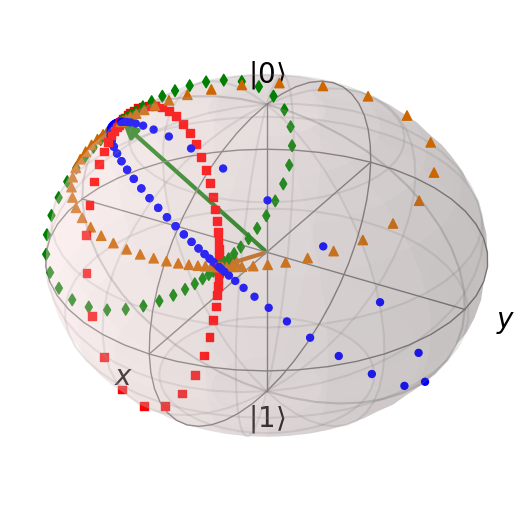

In [351]:
b.clear()
ψ, ϕ = qu.rand_ket(2), qu.rand_ket(2)
b.add_states([ψ, ϕ])
interp = [[(cos(θ)^2 * ψ + exp(im*α) * sin(θ)^2 * ϕ) / (cos(θ)^2 * ψ + exp(im*α) * sin(θ)^2 * ϕ).norm()
        for θ in range(0, π/2, length=32)] for α in 0:π/4:2π];
b.add_states(interp, "point")
b

In [103]:
J = Jωs[0g][1]

4×4 Array{Sym,2}:
 sqrt(2)*g^2*(16*g^2 + 12)  0  0  sqrt(2)*(8*g^3 + 4*g)
                         0  0  0                      0
                         0  0  0                      0
     sqrt(2)*(8*g^3 + 4*g)  0  0          4*sqrt(2)*g^2

In [105]:
([1, 1] / √2) ⊗ₖ ([1, 0])

4-element Array{Float64,1}:
 0.7071067811865475
 0.0
 0.7071067811865475
 0.0

In [393]:
function add_jump!(b, J, ψ, g0)
    ϕ = map(SymPy.N ∘ subs(g => g0), J * ψ)
    ρ1 = ptrace(qoket(ϕ), 2)
    B = [qu.ket([0,0]), qu.ket([0,1]), qu.ket([1,0]), qu.ket([1,1])]
    s = sum(x*y for (x, y) in zip(B, ϕ))
    b.add_states(s, "points")
    b
end;

In [318]:
using QuantumOptics
qoket(ψ) = Ket(SpinBasis(1//2) ⊗ SpinBasis(1//2), ψ[[1,3,2,4]])
plainket(ψ) = ψ[[1,3,2,4]];

## The Bloch sphere

In [229]:
using CairoMakie
AbstractPlotting.inline!(true)

In [203]:
using CoordinateTransformations

In [209]:
CartesianFromSpherical()(Spherical(1, π/2, π/2))

3-element StaticArrays.SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
 3.749399456654644e-33
 6.123233995736766e-17
 1.0

In [255]:
function blochpoint(ψ)
    ψ1, ψ2 = ψ[1], ψ[2]
    α = angle(ψ1)
    phase = exp(-im*α)
    ψ1 *= phase
    ψ2 *= phase
    ϕ = real(angle(ψ2))
    θ = real(2*acos(ψ1))
    CartesianFromSpherical()(Spherical(1, θ, ϕ))
end

plotblochpoint!(ψ; kwargs...) = mesh!(Sphere(Point3f0(blochpoint(ψ)...), 0.05f0), shading = true, kwargs...);

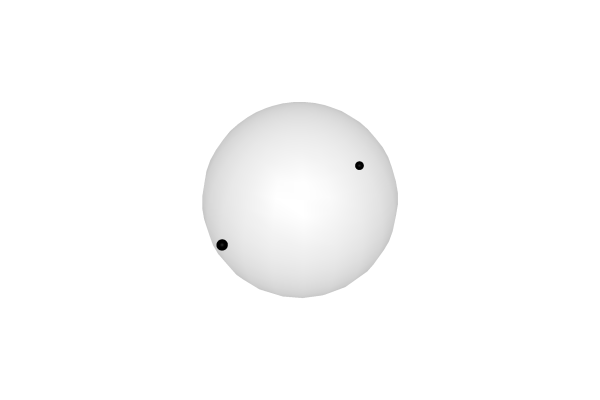

In [258]:
mesh(Sphere(Point3f0(0), 1f0), color = RGBA(1.,1.,1.,0.5), shading = true, show_axis=false)
plotblochpoint!([1, 0])
plotblochpoint!([0, 1])
current_figure()

In [432]:
?RGBA

search: RGBA RGBAf0 rgba_string Rangebars rangebars rangebars! AbstractRGBA



No documentation found.

`ColorTypes.RGBA` is of type `UnionAll`.

# Summary

```
struct UnionAll <: Type{T}
```

# Fields

```
var  :: TypeVar
body :: Any
```

# Supertype Hierarchy

```
UnionAll <: Type{T} <: Any
```


In [329]:
function blochballpoint(ρ::Operator)
    vals, vecs = eigen(ρ.data)
    sum(p * blochpoint(vecs[:,i]) for (i, p) in enumerate(vals))
end;

blochballpoint(ψ::Vector) = blochballpoint(ptrace(qoket(ψ), 2));

In [396]:
function jump_point(J, ψ, g0)
    ϕ = map(SymPy.N ∘ subs(g => g0), J * ψ)
    ϕ /= norm(ϕ)
    blochballpoint(ϕ)
end;

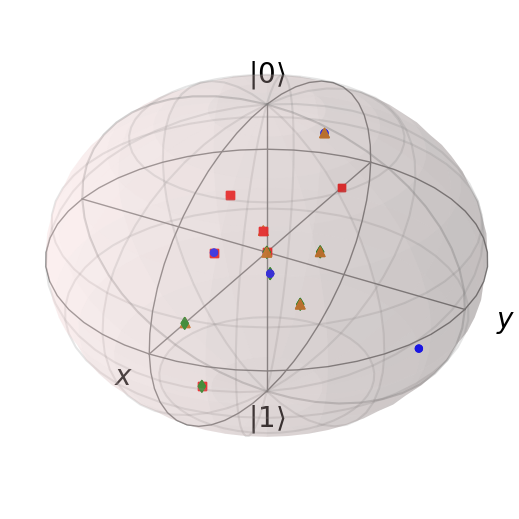

In [427]:
ψ = rand(4) + im*rand(4)
ψ /= norm(ψ)
b0 = blochballpoint(ψ)
b1s = [[jump_point(J, ψ, 1.0) for J in Js] for Js in values(Jωs)]

b = qu.Bloch()
b.clear()
b.add_points(b0)
for b1 in b1s
    b.add_points.(b1)
end
b

In [428]:
arrow!(tail, head; kwargs...) = arrows!((x -> [x]).(tail)..., (x -> [x]).(head - tail)..., arrowsize=0.1, kwargs...);

In [430]:
WGLMakie.activate!()

In [431]:
mesh(Sphere(Point3f0(0), 1f0), color = RGBA(1.,1.,1.,0.5), shading = true, show_axis=false)
plotblochpoint!([1, 0])
plotblochpoint!([0, 1])
for bJs in b1s
    for b1 in bJs
        arrow!(b0, b1)
    end
end
current_figure()